In [1]:
print("hiz")

hiz


In [2]:
import logging
import torch
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import torchvision.transforms.v2 as transforms
import numpy as np
from pothole.datasets import PotholeDataset
logging.basicConfig(level=logging.INFO, format='%(name)s: %(message)s')

In [3]:
logging.getLogger().setLevel(logging.DEBUG)
LOG = logging.getLogger(__name__)

In [4]:
# torch.cuda.set_device(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


matplotlib: matplotlib data path: /zhome/25/e/155273/Desktop/02516_dvcv/02516_venv/lib/python3.11/site-packages/matplotlib/mpl-data
matplotlib: CONFIGDIR=/zhome/25/e/155273/.config/matplotlib
matplotlib: interactive is False
matplotlib: platform is linux


matplotlib: CACHEDIR=/zhome/25/e/155273/.cache/matplotlib
matplotlib.font_manager: Using fontManager instance from /zhome/25/e/155273/.cache/matplotlib/fontlist-v330.json
matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager: findfont: score(FontEntry(fname='/zhome/25/e/155273/Desktop/02516_dvcv/02516_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
matplotlib.font_manager: findfont: score(FontEntry(fname='/zhome/25/e/155273/Desktop/02516_dvcv/02516_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFive

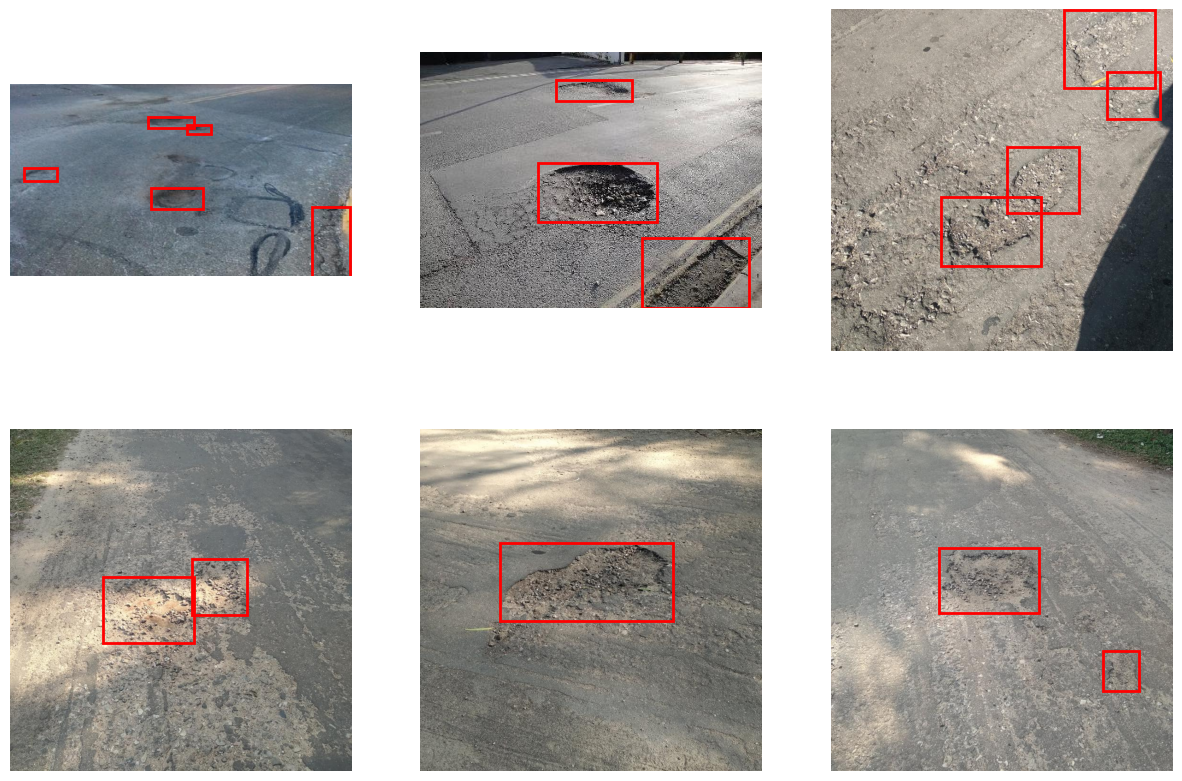

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import random
import xml.etree.ElementTree as ET

# Directory containing the images and XML files
directory = "/zhome/25/e/155273/Desktop/02516_dvcv/02516_pothole_w3/data/Potholes/annotated-images"

# Generate a list of image file names and their corresponding XML files
image_files = [f"img-{i}.jpg" for i in range(1, 632)]
xml_files = [f"img-{i}.xml" for i in range(1, 632)]

# Randomly select 6 image files and their corresponding XML files
selected_indices = random.sample(range(1, 632), 6)
selected_image_paths = [os.path.join(directory, image_files[i-1]) for i in selected_indices]
selected_xml_paths = [os.path.join(directory, xml_files[i-1]) for i in selected_indices]

# Set up the figure and axes for a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Function to parse bounding boxes from XML file
def parse_bndbox(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndboxes = []
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        bndboxes.append((xmin, ymin, xmax, ymax))
    return bndboxes

# Display images with bounding boxes
for ax, img_path, xml_path in zip(axes.ravel(), selected_image_paths, selected_xml_paths):
    # Read image and corresponding XML file
    img = mpimg.imread(img_path)
    bndboxes = parse_bndbox(xml_path)
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Add bounding boxes to the image
    for (xmin, ymin, xmax, ymax) in bndboxes:
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        # rect = patches.Rectangle((50, 50), 150, 100, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)





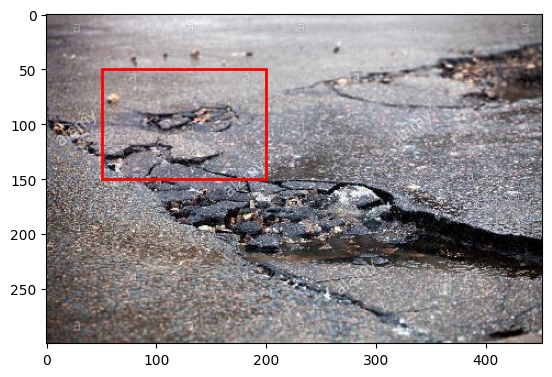

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# Load the image
img_path = "/zhome/25/e/155273/Desktop/02516_dvcv/02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg"  # Replace with the path to your actual image
img = mpimg.imread(img_path)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a rectangle patch
rect = patches.Rectangle((50, 50), 150, 100, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the Axes
ax.add_patch(rect)

# Show the plot
plt.show()


In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [15]:
import torchvision.datasets as datasets
image_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        # transforms.Resize((224, 224)),
    ])
trainset = PotholeDataset("train", image_transform=image_transform)
testset = PotholeDataset("validation", image_transform=image_transform)
valset = PotholeDataset("test", image_transform=image_transform)


batch_size = 1
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)

In [16]:
foo, bar = trainset[0]
print(f'img: {foo.shape}, label: {bar}')

for i, (img, label) in enumerate(train_loader):
    print(f'img: {img.shape}, label: {label.shape}')
    if i == 3:
        break
# img, label = next(iter(train_loader))
# print(label.shape)
# print(img)

img: torch.Size([3, 720, 720]), label: tensor([[224, 290, 638, 411],
        [ 82, 184, 180, 211]])


img: torch.Size([1, 3, 300, 464]), label: torch.Size([1, 1, 4])
img: torch.Size([1, 3, 300, 400]), label: torch.Size([1, 1, 4])
img: torch.Size([1, 3, 720, 720]), label: torch.Size([1, 2, 4])
img: torch.Size([1, 3, 720, 720]), label: torch.Size([1, 2, 4])


In [ ]:
def selective_search(image_path, method="fast"):
    image = cv2.imread(image_path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)
    
    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    return rects

# Load the image
img_path = "/zhome/25/e/155273/Desktop/02516_dvcv/02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg"  # Replace with the path to your actual image


# Show the plot
print(selective_search(img_path))

[[265 257  29  14]
 [109 128  49  12]
 [ 25 128  54  53]
 ...
 [ 89   9 363 205]
 [  0   0 258 300]
 [  0   0 452 214]]


In [ ]:
#Currently
#3
#Fix dataloder
#Use IoU for 

#Determine number of required proposals?

#4
#Assign labels to proposals